### 쌀 종류 분류 문제 다뤄보기

데이터 출처 : 캐글

클래스 수 : 5 (Arborio, Basmati, Ipsala, Jasmine, Karacadag)

### 필요 라이브러리 import

In [16]:
import matplotlib as mlp
import splitfolders
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import warnings
from keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
import os
import random

warnings.filterwarnings("ignore")
mlp.rcParams["font.family"] = "Malgun Gothic"

### 데이터셋 분할

In [2]:
splitfolders.ratio("./data/Rice_Image_Dataset/", ratio = (0.7, 0.2, 0.1), seed = 1337)

### 데이터셋 살펴보기

(250, 250, 3)


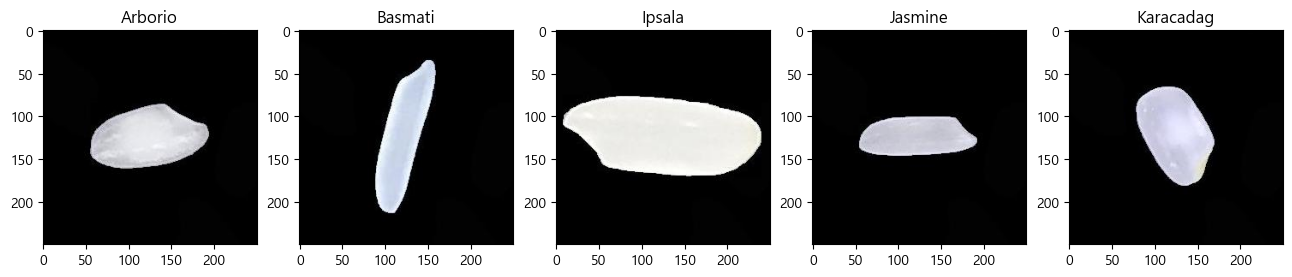

In [3]:
plt.figure(figsize=(16, 12))
plt.subplot(1, 5, 1)
image1 = cv2.imread("./output/train/Arborio/Arborio (10001).jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.title("Arborio")
plt.imshow(image1)

plt.subplot(1, 5, 2)
image2 = cv2.imread("./output/train/Basmati/Basmati (1).jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.title("Basmati")
plt.imshow(image2)

plt.subplot(1, 5, 3)
image3 = cv2.imread("./output/train/Ipsala/Ipsala (1).jpg")
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
plt.title("Ipsala")
plt.imshow(image3)

plt.subplot(1, 5, 4)
image4 = cv2.imread("./output/train/Jasmine/Jasmine (1).jpg")
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
plt.title("Jasmine")
plt.imshow(image4)

plt.subplot(1, 5, 5)
image5 = cv2.imread("./output/train/Karacadag/Karacadag (1).jpg")
print(image5.shape)
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2RGB)
plt.title("Karacadag")
plt.imshow(image5)

### 각 세트 별 이미지 분포 확인

In [4]:
# 훈련셋 이미지 개수
train_imgs_dir = glob("./output/train/*")
valid_imgs_dir = glob("./output/val/*")
test_imgs_dir = glob("./output/test/*")

train_imgs_x = []
train_imgs_y = []
validation_imgs_x = []
validation_imgs_y = []
test_imgs_x = []
test_imgs_y = []

for dir in train_imgs_dir:
    dir_name = dir[dir.rfind("\\") + 1:]
    train_imgs_x.append(dir_name)
    train_imgs_y.append(len(glob(f'{dir}/*.jpg')))

for dir in valid_imgs_dir:
    dir_name = dir[dir.rfind("\\") + 1:]
    validation_imgs_x.append(dir_name)
    validation_imgs_y.append(len(glob(f'{dir}/*.jpg')))

for dir in test_imgs_dir:
    dir_name = dir[dir.rfind("\\") + 1:]
    test_imgs_x.append(dir_name)
    test_imgs_y.append(len(glob(f'{dir}/*.jpg')))

Text(0, 0.5, '이미지 개수')

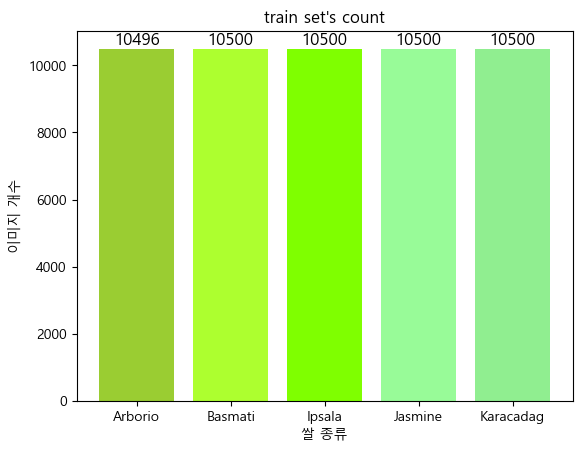

In [5]:
bar = plt.bar(test_imgs_x, train_imgs_y, label = "train set", color = ["yellowgreen", "greenyellow", "chartreuse", "palegreen", "lightgreen"])

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2.0,height,  height, ha = 'center',va='bottom',size=12)

plt.title("train set's count")
plt.xlabel("쌀 종류")
plt.ylabel("이미지 개수")

### 이미지 전처리
이미지 증강처리, 학습 데이터 구성

In [6]:
train_generator = ImageDataGenerator(
    rescale = 1. / 255. ,
    rotation_range = 40,
    width_shift_range = 0.3,
    vertical_flip = True
)

validation_generator = ImageDataGenerator(
    rescale = 1. / 255.
)

train_dataset = train_generator.flow_from_directory(
    directory = "./output/train/",
    target_size = (250, 250),
    class_mode = "categorical",
    batch_size = 16,
    color_mode = "rgb"
)

validation_dataset = validation_generator.flow_from_directory(
    directory = "./output/val/",
    target_size = (250, 250),
    class_mode = "categorical",
    batch_size = 16,
    color_mode = "rgb"
)

Found 52496 images belonging to 5 classes.
Found 14999 images belonging to 5 classes.


### 모델링

In [13]:
def get_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides = (2, 2), input_shape = (250, 250, 3), activation = "relu", padding = "same"))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), strides = (2, 2), activation = "relu", padding = "same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3, 3), strides = (2, 2), activation = "relu", padding = "same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), strides = (2, 2), activation = "relu", padding = "same"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(5, activation = "softmax"))
    
    return model

model = get_model()

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      1792      
                                                                 
 dropout_6 (Dropout)         (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 256)        

### Callback 함수 정의

In [14]:
els = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
mcp = ModelCheckpoint("./model/weights/{epoch:02d}-{loss:.2f}.hdf5", monitor = "val_loss", save_best_only = True, mode = "min")
rlr = ReduceLROnPlateau(monitor = "val_acc", factor = 0.3, patience = 5, mode = "min")

if not os.path.isdir("./model/csv_files") and not os.path.isdir("./model"):
    os.mkdir("./model")
    os.mkdir('./model/csv_files')
    
csv = CSVLogger("./model/csv_files/training.csv")

callbacks = [els, mcp, rlr, csv]

### 모델 학습

In [19]:
if len(os.listdir("./model/weights/")) != 0:
    for file in os.listdir("./model/weights/"):
        os.remove(f"./model/weights/{file}")

model.fit(train_dataset, epochs = 100, callbacks=callbacks, validation_data = validation_dataset)

Epoch 1/100
3281/3281 [==============================] - 351s 107ms/step - loss: 0.2467 - acc: 0.9063 - val_loss: 0.0897 - val_acc: 0.9711 - lr: 0.0010
Epoch 2/100
3281/3281 [==============================] - 358s 109ms/step - loss: 0.1277 - acc: 0.9572 - val_loss: 0.0830 - val_acc: 0.9723 - lr: 0.0010
Epoch 3/100
3281/3281 [==============================] - 353s 108ms/step - loss: 0.0805 - acc: 0.9739 - val_loss: 0.0910 - val_acc: 0.9655 - lr: 0.0010
Epoch 4/100
3281/3281 [==============================] - 355s 108ms/step - loss: 0.0618 - acc: 0.9801 - val_loss: 0.0587 - val_acc: 0.9821 - lr: 0.0010
Epoch 5/100
3281/3281 [==============================] - 357s 109ms/step - loss: 0.0502 - acc: 0.9842 - val_loss: 0.0411 - val_acc: 0.9885 - lr: 0.0010
Epoch 6/100
3281/3281 [==============================] - 360s 110ms/step - loss: 0.0452 - acc: 0.9858 - val_loss: 0.0229 - val_acc: 0.9931 - lr: 0.0010
Epoch 7/100
3281/3281 [==============================] - 365s 111ms/step - loss: 0.0436 

### 학습곡선 시각화

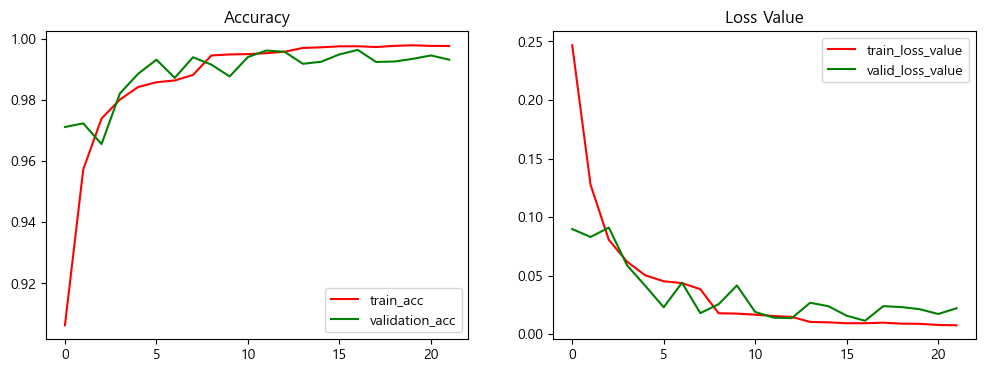

In [35]:
df = pd.read_csv('./model/csv_files/training.csv')

epochs = df['epoch'].values
train_acc = df['acc'].values
valid_acc = df['val_acc'].values
train_loss = df['loss'].values
val_loss = df['val_loss'].values

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label = "train_acc", color = "r")
plt.plot(epochs, valid_acc, label = "validation_acc", color = "g")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label = "train_loss_value", color = "r")
plt.plot(epochs, val_loss, label = "valid_loss_value", color = "g")
plt.legend()
plt.title("Loss Value")

plt.show()

In [22]:
weight = f"./model/weights/{os.listdir('./model/weights/')[-1]}"

model = get_model()
model.load_weights(weight)

In [23]:
import tensorflow as tf

def read_image(path):                       
    gfile = tf.io.read_file(path)          
    image = tf.io.decode_image(gfile, dtype=tf.float32) 
    
    return image

In [34]:
test_data_path = glob("./output/test/*/*.jpg")
random.shuffle(test_data_path)

labels = {0 : "Arborio", 1 : "Basmati", 2 : "Ipsala", 3 : "Jasmine", 4 : "Karacadag"}
for data_no in range(15):
    path = test_data_path[data_no]
    y_true = path[path.rfind("\\") + 1 : path.rfind(" ")]
    
    img = read_image(path)
    img = tf.image.resize(img, (250, 250))

    img = np.array(img)
    # plt.imshow(img)
    # plt.title(f"{y_true}")
    print(f"해당 이미지 레이블 : {y_true}")
    test_image = img[tf.newaxis, ...]
    print(f"모델에 의해 예측된 레이블 : {labels[np.argmax(model.predict(test_image))]}")

해당 이미지 레이블 : Arborio
1/1 [==============================] - 0s 18ms/step
모델에 의해 예측된 레이블 : Arborio
해당 이미지 레이블 : Jasmine
1/1 [==============================] - 0s 16ms/step
모델에 의해 예측된 레이블 : Jasmine
해당 이미지 레이블 : Jasmine
1/1 [==============================] - 0s 16ms/step
모델에 의해 예측된 레이블 : Jasmine
해당 이미지 레이블 : Ipsala
1/1 [==============================] - 0s 15ms/step
모델에 의해 예측된 레이블 : Ipsala
해당 이미지 레이블 : Arborio
1/1 [==============================] - 0s 16ms/step
모델에 의해 예측된 레이블 : Arborio
해당 이미지 레이블 : Jasmine
1/1 [==============================] - 0s 16ms/step
모델에 의해 예측된 레이블 : Jasmine
해당 이미지 레이블 : Arborio
1/1 [==============================] - 0s 14ms/step
모델에 의해 예측된 레이블 : Arborio
해당 이미지 레이블 : Jasmine
1/1 [==============================] - 0s 15ms/step
모델에 의해 예측된 레이블 : Jasmine
해당 이미지 레이블 : Jasmine
1/1 [==============================] - 0s 15ms/step
모델에 의해 예측된 레이블 : Jasmine
해당 이미지 레이블 : Karacadag
1/1 [==============================] - 0s 15ms/step
모델에 의해 예측된 레이블 : Karacadag
해당 이미지 레이블 : Ipsal